In [1]:
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import numpy.ma as ma
from scipy.interpolate import griddata
from pyresample import geometry,image, kd_tree
import copy

In [8]:
# Option
dave_mc=False

## Code to plot the impact from CO2 and climate separately
# Control - noclimate = Climate impact
# Control - noco2 = CO2 effect

# Open NCSCD as observation
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscdv2_soilc_0.5x0.5.nc'
#path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscd_masked_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
nclu_obs.close()
soc_ncscd = soc_ncscd_orig[0,:,:]

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)

# 1D time series
respath_ctrl='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_1d_noclim_noco2'
respath_noclim='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_1d_noclim'
respath_noco2='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_1d_noco2'
flist = ['mean_bgc3d_1861_1870.nc', 'mean_bgc3d_1871_1880.nc', 'mean_bgc3d_1881_1890.nc', 'mean_bgc3d_1891_1900.nc', \
        'mean_bgc3d_1901_1910.nc', 'mean_bgc3d_1911_1920.nc', 'mean_bgc3d_1921_1930.nc', 'mean_bgc3d_1931_1940.nc', \
        'mean_bgc3d_1941_1950.nc', 'mean_bgc3d_1951_1960.nc', 'mean_bgc3d_1961_1970.nc', 'mean_bgc3d_1971_1980.nc', \
        'mean_bgc3d_1981_1990.nc', 'mean_bgc3d_1991_2000.nc', 'mean_bgc3d_2001_2010.nc', 'mean_bgc3d_2011_2020.nc', \
        'mean_bgc3d_2021_2030.nc', 'mean_bgc3d_2031_2040.nc', 'mean_bgc3d_2041_2050.nc', 'mean_bgc3d_2051_2060.nc', \
        'mean_bgc3d_2061_2070.nc', 'mean_bgc3d_2071_2080.nc', 'mean_bgc3d_2081_2090.nc', 'mean_bgc3d_2091_2100.nc']

flen = len(flist)

soc_ctrl = np.zeros((flen, 360, 720))
soc_noclim = np.zeros((flen, 360, 720))
soc_noco2 = np.zeros((flen, 360, 720))
soc_top_ctrl = np.zeros((flen, 360, 720))
soc_top_noclim = np.zeros((flen, 360, 720))
soc_top_noco2 = np.zeros((flen, 360, 720))
soc_sub_ctrl = np.zeros((flen, 360, 720))
soc_sub_noclim = np.zeros((flen, 360, 720))
soc_sub_noco2 = np.zeros((flen, 360, 720))

for i in np.arange(0,flen):
    # 1D
    print(flist[i])
    fp=respath_ctrl+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    soclev_ctrl = nclu.variables['soil_c_lev'][:]
    resplev_ctrl = nclu.variables['resp_lev'][:]
    latnc = nclu.variables['lat'][:]
    lonnc = nclu.variables['lon'][:]
    nclu.close()
    
    fp=respath_noclim+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    soclev_noclim = nclu.variables['soil_c_lev'][:]
    resplev_noclim = nclu.variables['resp_lev'][:]
    nclu.close()

    fp=respath_noco2+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    soclev_noco2 = nclu.variables['soil_c_lev'][:]
    resplev_noco2 = nclu.variables['resp_lev'][:]
    nclu.close()

    # Get the topsoil SOC (0-30cm) from 1D model
    soc_top_ctrl[i,:,:] = np.sum(soclev_ctrl[0:5,:,:], 0)
    soc_top_noclim[i,:,:] = np.sum(soclev_noclim[0:5,:,:], 0)
    soc_top_noco2[i,:,:] = np.sum(soclev_noco2[0:5,:,:], 0)
    
    soc_sub_ctrl[i,:,:] = np.sum(soclev_ctrl[5:7,:,:], 0)+0.3*soclev_ctrl[7,:,:]
    soc_sub_noclim[i,:,:] = np.sum(soclev_noclim[5:7,:,:], 0)+0.3*soclev_noclim[7,:,:]
    soc_sub_noco2[i,:,:] = np.sum(soclev_noco2[5:7,:,:], 0)+0.3*soclev_noco2[7,:,:]
    
    soc_ctrl[i,:,:] = soc_top_ctrl[i,:,:] + soc_sub_ctrl[i,:,:]
    soc_noclim[i,:,:] = soc_top_noclim[i,:,:] + soc_sub_noclim[i,:,:]
    soc_noco2[i,:,:] = soc_top_noco2[i,:,:] + soc_sub_noco2[i,:,:]
    

# 0D time series
respath_ctrl='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_0d'
respath_noclim='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_0d_noclim'
respath_noco2='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_0d_noco2'
flist = ['mean_bgc2d_1861_1870.nc', 'mean_bgc2d_1871_1880.nc', 'mean_bgc2d_1881_1890.nc', 'mean_bgc2d_1891_1900.nc', \
        'mean_bgc2d_1901_1910.nc', 'mean_bgc2d_1911_1920.nc', 'mean_bgc2d_1921_1930.nc', 'mean_bgc2d_1931_1940.nc', \
        'mean_bgc2d_1941_1950.nc', 'mean_bgc2d_1951_1960.nc', 'mean_bgc2d_1961_1970.nc', 'mean_bgc2d_1971_1980.nc', \
        'mean_bgc2d_1981_1990.nc', 'mean_bgc2d_1991_2000.nc', 'mean_bgc2d_2001_2010.nc']
flen_0 = len(flist)    
soc0d_ctrl = np.zeros((flen_0, 360, 720))
soc0d_noclim = np.zeros((flen_0, 360, 720))
soc0d_noco2 = np.zeros((flen_0, 360, 720))


for i in np.arange(0,flen_0):
    # 1D
    print(flist[i])
    fp=respath_ctrl+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    soc_0d_ctrl = nclu.variables['soil_c'][:]
    resp_0d_ctrl = nclu.variables['resp'][:]
    latnc = nclu.variables['lat'][:]
    lonnc = nclu.variables['lon'][:]
    nclu.close()
    
    fp=respath_noclim+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    soc_0d_noclim = nclu.variables['soil_c'][:]
    resp_0d_noclim = nclu.variables['resp'][:]
    nclu.close()

    fp=respath_noco2+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    soc_0d_noco2 = nclu.variables['soil_c'][:]
    resp_0d_noco2 = nclu.variables['resp'][:]
    nclu.close()
   
    soc0d_ctrl[i,:,:] = soc_0d_ctrl
    soc0d_noclim[i,:,:] = soc_0d_noclim
    soc0d_noco2[i,:,:] = soc_0d_noco2




mean_bgc3d_1861_1870.nc
mean_bgc3d_1871_1880.nc
mean_bgc3d_1881_1890.nc
mean_bgc3d_1891_1900.nc
mean_bgc3d_1901_1910.nc
mean_bgc3d_1911_1920.nc
mean_bgc3d_1921_1930.nc
mean_bgc3d_1931_1940.nc
mean_bgc3d_1941_1950.nc
mean_bgc3d_1951_1960.nc
mean_bgc3d_1961_1970.nc
mean_bgc3d_1971_1980.nc
mean_bgc3d_1981_1990.nc
mean_bgc3d_1991_2000.nc
mean_bgc3d_2001_2010.nc
mean_bgc3d_2011_2020.nc
mean_bgc3d_2021_2030.nc
mean_bgc3d_2031_2040.nc
mean_bgc3d_2041_2050.nc
mean_bgc3d_2051_2060.nc
mean_bgc3d_2061_2070.nc
mean_bgc3d_2071_2080.nc
mean_bgc3d_2081_2090.nc
mean_bgc3d_2091_2100.nc
mean_bgc2d_1861_1870.nc
mean_bgc2d_1871_1880.nc
mean_bgc2d_1881_1890.nc
mean_bgc2d_1891_1900.nc
mean_bgc2d_1901_1910.nc
mean_bgc2d_1911_1920.nc
mean_bgc2d_1921_1930.nc
mean_bgc2d_1931_1940.nc
mean_bgc2d_1941_1950.nc
mean_bgc2d_1951_1960.nc
mean_bgc2d_1961_1970.nc
mean_bgc2d_1971_1980.nc
mean_bgc2d_1981_1990.nc
mean_bgc2d_1991_2000.nc
mean_bgc2d_2001_2010.nc


In [ ]:
a = [-2, -1, 0, 1, 2]

In [ ]:
len(np.where(a <0)[0])

In [10]:
# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent

# soc_ctrl_perm = copy.deepcopy(soc_ctrl)
# soc_noclim_perm = copy.deepcopy(soc_noclim)
# soc_noco2_perm = copy.deepcopy(soc_noco2)
# soc0d_ctrl_perm = copy.deepcopy(soc0d_ctrl)
# soc0d_noclim_perm = copy.deepcopy(soc0d_noclim)
# soc0d_noco2_perm = copy.deepcopy(soc0d_noco2)

# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
#val = np.ones((nlat, nlon))*float("nan")
#val_0d = np.ones((nlat, nlon))*float("nan")
#val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

soc1d_ctrl_ts = np.zeros((flen))
soc1d_noclim_ts = np.zeros((flen))
soc1d_noco2_ts = np.zeros((flen))
soc1d_top_ctrl_ts = np.zeros((flen))
soc1d_top_noclim_ts = np.zeros((flen))
soc1d_top_noco2_ts = np.zeros((flen))
soc1d_sub_ctrl_ts = np.zeros((flen))
soc1d_sub_noclim_ts = np.zeros((flen))
soc1d_sub_noco2_ts = np.zeros((flen))

soc0d_ctrl_ts = np.zeros((flen_0))
soc0d_noclim_ts = np.zeros((flen_0))
soc0d_noco2_ts = np.zeros((flen_0))

for i in np.arange(0,flen):
    soc_ctrl_perm =  ma.masked_array(soc_ctrl[i,:,:], mask=another_mask.mask)
    soc_noclim_perm =  ma.masked_array(soc_noclim[i,:,:], mask=another_mask.mask)
    soc_noco2_perm =  ma.masked_array(soc_noco2[i,:,:], mask=another_mask.mask)
    soc_top_ctrl_perm =  ma.masked_array(soc_top_ctrl[i,:,:], mask=another_mask.mask)
    soc_top_noclim_perm =  ma.masked_array(soc_top_noclim[i,:,:], mask=another_mask.mask)
    soc_top_noco2_perm =  ma.masked_array(soc_top_noco2[i,:,:], mask=another_mask.mask)
    soc_sub_ctrl_perm =  ma.masked_array(soc_sub_ctrl[i,:,:], mask=another_mask.mask)
    soc_sub_noclim_perm =  ma.masked_array(soc_sub_noclim[i,:,:], mask=another_mask.mask)
    soc_sub_noco2_perm =  ma.masked_array(soc_sub_noco2[i,:,:], mask=another_mask.mask)
    if (i<flen_0):
        soc0d_ctrl_perm =  ma.masked_array(soc0d_ctrl[i,:,:], mask=another_mask.mask)
        soc0d_noclim_perm =  ma.masked_array(soc0d_noclim[i,:,:], mask=another_mask.mask)
        soc0d_noco2_perm =  ma.masked_array(soc0d_noco2[i,:,:], mask=another_mask.mask)
    
    val_ctrl = soc_ctrl_perm * grid_area
    val_noclim = soc_noclim_perm * grid_area
    val_noco2 = soc_noco2_perm * grid_area
    val_top_ctrl = soc_top_ctrl_perm * grid_area
    val_top_noclim = soc_top_noclim_perm * grid_area
    val_top_noco2 = soc_top_noco2_perm * grid_area
    val_sub_ctrl = soc_sub_ctrl_perm * grid_area
    val_sub_noclim = soc_sub_noclim_perm * grid_area
    val_sub_noco2 = soc_sub_noco2_perm * grid_area
    if (i<flen_0):
        val0d_ctrl = soc0d_ctrl_perm * grid_area
        val0d_noclim = soc0d_noclim_perm * grid_area
        val0d_noco2 = soc0d_noco2_perm * grid_area
    
    soc1d_ctrl_ts[i] = np.nansum(val_ctrl)/1e12
    soc1d_noclim_ts[i] = np.nansum(val_noclim)/1e12
    soc1d_noco2_ts[i] = np.nansum(val_noco2)/1e12
    soc1d_top_ctrl_ts[i] = np.nansum(val_top_ctrl)/1e12
    soc1d_top_noclim_ts[i] = np.nansum(val_top_noclim)/1e12
    soc1d_top_noco2_ts[i] = np.nansum(val_top_noco2)/1e12
    soc1d_sub_ctrl_ts[i] = np.nansum(val_sub_ctrl)/1e12
    soc1d_sub_noclim_ts[i] = np.nansum(val_sub_noclim)/1e12
    soc1d_sub_noco2_ts[i] = np.nansum(val_sub_noco2)/1e12
    
    if (i<flen_0):
        soc0d_ctrl_ts[i] = np.nansum(val0d_ctrl)/1e12
        soc0d_noclim_ts[i] = np.nansum(val0d_noclim)/1e12
        soc0d_noco2_ts[i] = np.nansum(val0d_noco2)/1e12
    
       

In [11]:
# CO2 fertilize
co2_ts = soc1d_noclim_ts - soc1d_ctrl_ts
clim_ts = soc1d_noco2_ts - soc1d_ctrl_ts
co2_top_ts = soc1d_top_noclim_ts - soc1d_top_ctrl_ts
clim_top_ts = soc1d_top_noco2_ts - soc1d_top_ctrl_ts
co2_sub_ts = soc1d_sub_noclim_ts - soc1d_sub_ctrl_ts
clim_sub_ts = soc1d_sub_noco2_ts - soc1d_sub_ctrl_ts
co20d_ts = soc0d_ctrl_ts - soc0d_noco2_ts
clim0d_ts = soc0d_ctrl_ts - soc0d_noclim_ts

In [12]:
all_ts = np.zeros((flen))
all_top_ts = np.zeros((flen))
all_sub_ts = np.zeros((flen))
for i in np.arange(0,flen):
    all_ts[i] = co2_ts[i]+clim_ts[i]
    all_top_ts[i] = co2_top_ts[i]+clim_top_ts[i]
    all_sub_ts[i] = co2_sub_ts[i]+clim_sub_ts[i]

In [13]:
all0d_ts = np.zeros((flen_0))
for i in np.arange(0,flen_0):
    all0d_ts[i] = soc0d_ctrl_ts[i] - soc0d_ctrl_ts[0]

In [14]:
all_ts

array([5.74493150e-03, 5.62695744e-02, 1.68961585e-01, 3.63421808e-01,
       6.20242563e-01, 9.21586163e-01, 1.20434835e+00, 1.47948420e+00,
       1.77814972e+00, 2.21369517e+00, 2.45711278e+00, 2.93259784e+00,
       3.39283752e+00, 3.72608135e+00, 3.69182776e+00, 3.60996394e+00,
       4.18798016e+00, 4.76573018e+00, 5.16317376e+00, 5.81372355e+00,
       6.09426920e+00, 5.83206256e+00, 5.90800639e+00, 5.90552198e+00])

In [15]:
all_top_ts

array([4.99215574e-03, 4.66500800e-02, 1.37506452e-01, 2.92165618e-01,
       4.91125164e-01, 7.21249841e-01, 9.09472081e-01, 1.09710837e+00,
       1.32452590e+00, 1.63818421e+00, 1.88589480e+00, 2.30612799e+00,
       2.78379275e+00, 3.20516654e+00, 3.37671767e+00, 3.63785399e+00,
       4.49159250e+00, 5.16115712e+00, 5.81303366e+00, 6.68638598e+00,
       7.26189266e+00, 7.53829338e+00, 8.16835418e+00, 8.65608246e+00])

In [16]:
all_sub_ts

array([ 7.52775763e-04,  9.61949438e-03,  3.14551331e-02,  7.12561902e-02,
        1.29117399e-01,  2.00336321e-01,  2.94876270e-01,  3.82375837e-01,
        4.53623822e-01,  5.75510959e-01,  5.71217973e-01,  6.26469849e-01,
        6.09044774e-01,  5.20914808e-01,  3.15110085e-01, -2.78900478e-02,
       -3.03612348e-01, -3.95426934e-01, -6.49859897e-01, -8.72662426e-01,
       -1.16762346e+00, -1.70623082e+00, -2.26034779e+00, -2.75056048e+00])

In [17]:
all0d_ts

array([0.        , 0.01634314, 0.01156578, 0.17291849, 0.30874211,
       0.58055511, 0.58618656, 0.70397324, 0.83533832, 1.23785532,
       1.49840025, 1.97518742, 2.58459841, 3.08258744, 3.41426504])

In [18]:
co2_ts

array([5.74493150e-03, 5.62695744e-02, 1.68961585e-01, 3.63421808e-01,
       6.20242563e-01, 9.21586163e-01, 1.28765052e+00, 1.70156201e+00,
       2.14400762e+00, 2.57730589e+00, 3.09412278e+00, 3.78077443e+00,
       4.71754349e+00, 5.89052294e+00, 7.28655110e+00, 8.94191995e+00,
       1.09915860e+01, 1.33961282e+01, 1.61544829e+01, 1.92517775e+01,
       2.27225036e+01, 2.65188184e+01, 3.05910094e+01, 3.47821374e+01])

In [19]:
co2_top_ts

array([4.99215574e-03, 4.66500800e-02, 1.37506452e-01, 2.92165618e-01,
       4.91125164e-01, 7.21249841e-01, 9.96878249e-01, 1.30455277e+00,
       1.62785286e+00, 1.93826510e+00, 2.31360162e+00, 2.82004552e+00,
       3.51537696e+00, 4.37929833e+00, 5.39721909e+00, 6.59522113e+00,
       8.07001168e+00, 9.77075980e+00, 1.16908161e+01, 1.38025975e+01,
       1.61256954e+01, 1.86015627e+01, 2.11963273e+01, 2.37879641e+01])

In [20]:
co2_sub_ts

array([7.52775763e-04, 9.61949438e-03, 3.14551331e-02, 7.12561902e-02,
       1.29117399e-01, 2.00336321e-01, 2.90772274e-01, 3.97009238e-01,
       5.16154762e-01, 6.39040787e-01, 7.80521162e-01, 9.60728903e-01,
       1.20216653e+00, 1.51122461e+00, 1.88933201e+00, 2.34669882e+00,
       2.92157430e+00, 3.62536839e+00, 4.46366675e+00, 5.44918009e+00,
       6.59680819e+00, 7.91725566e+00, 9.39468206e+00, 1.09941733e+01])

In [21]:
co20d_ts

array([6.14032577e-03, 5.60966227e-02, 1.64726028e-01, 3.52445728e-01,
       5.93120442e-01, 8.83774544e-01, 1.22309997e+00, 1.61721583e+00,
       2.05061856e+00, 2.47327392e+00, 2.96894067e+00, 3.61996682e+00,
       4.49803531e+00, 5.61131642e+00, 6.94581130e+00])

In [22]:
clim_ts

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.08330217,  -0.2220778 ,
        -0.3658579 ,  -0.36361072,  -0.63701001,  -0.84817659,
        -1.32470597,  -2.16444159,  -3.59472335,  -5.331956  ,
        -6.80360583,  -8.63039801, -10.99130913, -13.43805399,
       -16.62823438, -20.68675583, -24.68300298, -28.87661542])

In [23]:
clim_top_ts

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.08740617,  -0.2074444 ,
        -0.30332696,  -0.3000809 ,  -0.42770682,  -0.51391754,
        -0.73158421,  -1.17413179,  -2.02050142,  -2.95736713,
        -3.57841917,  -4.60960268,  -5.87778248,  -7.11621147,
        -8.86380273, -11.06326935, -13.02797313, -15.13188162])

In [24]:
clim_sub_ts

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.10399579e-03, -1.46334008e-02,
       -6.25309401e-02, -6.35298279e-02, -2.09303189e-01, -3.34259053e-01,
       -5.93121758e-01, -9.90309806e-01, -1.57422192e+00, -2.37458887e+00,
       -3.22518665e+00, -4.02079533e+00, -5.11352665e+00, -6.32184251e+00,
       -7.76443165e+00, -9.62348648e+00, -1.16550298e+01, -1.37447338e+01])

In [25]:
clim0d_ts

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.23977171, -0.50823624, -0.69956244, -0.71855058,
       -0.88273266, -1.11182428, -1.35494209, -2.04525813, -2.99401702])

In [ ]:
co2_ts = all_ts - clim_ts
co20d_ts = all0d_ts - clim0d_ts

In [ ]:
soc1d_ctrl_ts

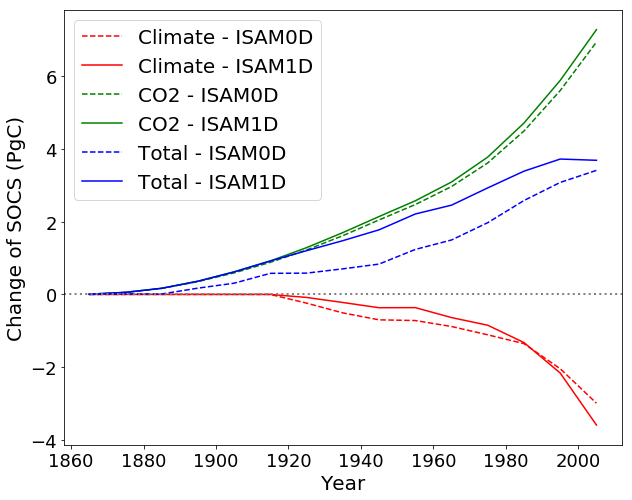

In [24]:
# Make plot of the time series
fig = plt.figure(figsize=(10,8))
x = [1865, 1875, 1885, 1895, 1905, 1915, 1925, 1935, 1945, 1955, 1965, 1975, 1985, 1995, 2005, 2015, 2025, 2035, 2045, 2055, \
    2065, 2075, 2085, 2095]
x0 = [1865, 1875, 1885, 1895, 1905, 1915, 1925, 1935, 1945, 1955, 1965, 1975, 1985, 1995, 2005]
plt.plot(x0, clim0d_ts, linestyle='--', color='red')
# plt.plot(x, clim_ts, linestyle='-', color='red')
plt.plot(x0, clim_ts[0:15], linestyle='-', color='red')
plt.plot(x0, co20d_ts, linestyle='--', color='green')
# plt.plot(x, co2_ts, linestyle='-', color='green')
plt.plot(x0, co2_ts[0:15], linestyle='-', color='green')
plt.plot(x0, all0d_ts, linestyle='--', color='blue')
# plt.plot(x, all_ts, linestyle='-', color='blue')
plt.plot(x0, all_ts[0:15], linestyle='-', color='blue')
plt.axhline(linewidth=2, linestyle=':', color='gray')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Change of SOCS (PgC)', fontsize=20)
plt.legend(['Climate - ISAM0D', 'Climate - ISAM1D', 'CO2 - ISAM0D', 'CO2 - ISAM1D', 'Total - ISAM0D', 'Total - ISAM1D'], fontsize=20)
#plt.savefig('./figures/fig12.png')

In [ ]:
soc1d_noclim_ts

In [ ]:
soc1d_noco2_ts

In [ ]:
soc0d_ctrl_ts

In [ ]:
soc0d_noclim_ts

In [ ]:
soc0d_ctrl_ts

In [ ]:
# ISAM-1D control 2000s ...
# 353.52246987372865
# ISAM-1D noclim 2000s ...
# 353.54943063669714
# ISAM-1D noco2 2000s ...
# 344.8873073819888
# ISAM-1D 1860s ...
# 343.61655160412346

# ISAM-0D control 2000s ...
# 180.7218003115083
# ISAM-0D noclim 2000s ...
# 183.71581733148145
# ISAM-0D noco2 2000s ...
# 173.77598900823125
# ISAM-0D control 1860s ...
# 177.30753527613672

In [ ]:
# Clim-1D: -1.0
# CO2-1D: 10.9
# Clim-1D: -3.6
# CO2-1D: 6.6

In [ ]:
soc_contemp_perm = copy.deepcopy(soc_contemp)

In [ ]:
plt.imshow(dsoc)

In [ ]:
# Mask all regions outside the northern permafrost extent
# Control
dsoc_perm = copy.deepcopy(dsoc)
dsoc_perm.mask = another_mask.mask
dsoc0d_perm = copy.deepcopy(dsoc0d)
dsoc0d_perm.mask = another_mask.mask
# No Climate
dsoc_noclim_perm = copy.deepcopy(dsoc_noclim)
dsoc_noclim_perm.mask = another_mask.mask
dsoc0d_noclim_perm = copy.deepcopy(dsoc0d_noclim)
dsoc0d_noclim_perm.mask = another_mask.mask
# No CO2
dsoc_noco2_perm = copy.deepcopy(dsoc_noco2)
dsoc_noco2_perm.mask = another_mask.mask
dsoc0d_noco2_perm = copy.deepcopy(dsoc0d_noco2)
dsoc0d_noco2_perm.mask = another_mask.mask

## Get into the story of tau later
# dtau_perm = copy.deepcopy(dtau)
# dtau_perm.mask = another_mask.mask
# dtau0d_perm = copy.deepcopy(dtau0d)
# dtau0d_perm.mask = another_mask.mask

# Plot the figure7
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(20,24))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM-0D change of SOC stock by CO2 fertilization (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,dsoc0d_perm[:,:] - dsoc0d_noco2_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
cbar = map.colorbar(cs1,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM-1D change of SOC stock by CO2 fertilization (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs2 = map.pcolormesh(x,y,dsoc_perm[:,:] - dsoc_noco2_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=0)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 


ax3 = fig.add_subplot(223)
ax3.set_title("ISAM-1D change of SOC stock by Climate (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,dsoc0d_perm[:,:] - dsoc0d_noclim_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.coolwarm) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs3,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(c)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM-0D change of SOC stock by Climate (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dsoc_perm[:,:] - dsoc_noclim_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.coolwarm) # use log color scale,

cbar = map.colorbar(cs4,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(d)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

#plt.show()
plt.savefig('./figures/fig10.png',dpi=300)

In [ ]:
dsoc_top_perm = soc_top_contemp_perm - soc_top_preind_perm
dsoc_sub_perm = soc_sub_contemp_perm - soc_sub_preind_perm

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM 1D topsoil SOC change (kgC/m2)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.bwr) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM 1D subsoil SOC change (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=10)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

# Set one colorbar for both subplots
# make an axes to put the shared colorbar in
#fig.subplots_adjust(bottom=0.1)
#colorbar_axes = plt.gcf().add_axes([0.35, 0.1, 0.3, 0.05])
#colorbar = plt.colorbar(cs, colorbar_axes, orientation='horizontal')
#colorbar_axes.tick_params(labelsize=20) 
#colorbar.set_label('Unit: $KgC m^{-2}$', fontsize=24)

plt.show()
#plt.savefig('./figures/fig8.png',dpi=300)

In [ ]:
# Plot the figure3
# Mask all regions outside the northern permafrost extent
resp_contemp_perm = copy.deepcopy(resp_contemp)
resp_contemp_perm.mask = another_mask.mask
resp0d_contemp_perm = copy.deepcopy(resp0d_contemp)
resp0d_contemp_perm.mask = another_mask.mask
resp_preind_perm = copy.deepcopy(resp_preind)
resp_preind_perm.mask = another_mask.mask
resp0d_preind_perm = copy.deepcopy(resp0d_preind)
resp0d_preind_perm.mask = another_mask.mask
dresp_perm = copy.deepcopy(dresp)
dresp_perm.mask = another_mask.mask
dresp0d_perm = copy.deepcopy(dresp0d)
dresp0d_perm.mask = another_mask.mask

# Comparison of Soil respiration and the change
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM 0D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,1000.*resp0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM 0D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp0d_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax3 = fig.add_subplot(223)
ax3.set_title("ISAM 1D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*resp_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM 1D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

plt.show()
#plt.savefig('Fig9.jpg',dpi=300)

In [ ]:
lonnc2

In [ ]:
lonnc2 % 360
